# Prediction of the "classification" label 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, RobertaModel, RobertaTokenizer, ViTModel, BlipProcessor, BlipForQuestionAnswering , CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup, AutoModelForSequenceClassification
import pickle 
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
df_combined = pd.read_csv('df_combined.csv')
df_combined

## NLP prediction

https://huggingface.co/BAAI/bge-reranker-large

## Version 3

In [ ]:
# Create a PyTorch dataset
class ClassifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len        

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = ClassifierDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

class Classifier(nn.Module):
    def __init__(self, n_classes, pretrained_model_base):
        super(Classifier, self).__init__()
        self.pretrained = pretrained_model_base
        self.drop = nn.Dropout(p=0.3)
        self.hidden = nn.Linear(self.pretrained.config.hidden_size, 128)  # Change 128 to your desired hidden layer size
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        text_output = self.pretrained(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        text_pooled_output = text_output.last_hidden_state[:, 0, :]
        
        output = self.drop(text_pooled_output)
        output = nn.ReLU()(self.hidden(output))
        # return self.out(output)
        return torch.nn.functional.log_softmax(self.out(output), dim=1)

In [ ]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# model_path = 'roberta-base'
# model_path = 'BAAI/bge-reranker-large'
# model_path = 'openbmb/Eurus-RM-7b' - has problems, TODO fix
model_path = 'facebook/bart-large-cnn'

tokenizer = AutoTokenizer.from_pretrained(model_path)
base_model = AutoModel.from_pretrained(model_path).to(device)

data_subset = df_combined#[:50]

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(data_subset['classification_by_editorial'])

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['text'], encoded_labels, test_size=0.2, random_state=42)

BATCH_SIZE = 116  # maximum for BGE is ~116
MAX_LEN = 256

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

# Initialize the classifier and optimizer
model = Classifier(len(le.classes_), base_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

STARTING Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:52<00:00,  1.50s/it]


Epoch 1/5, Train Loss: 0.10996797285651519, Test Loss: 0.04847493800229398
STARTING Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:50<00:00,  1.50s/it]


Epoch 2/5, Train Loss: 0.035287052065351245, Test Loss: 0.04888397057315119
STARTING Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:46<00:00,  1.49s/it]


Epoch 3/5, Train Loss: 0.0200300440547639, Test Loss: 0.04699889776926839
STARTING Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:53<00:00,  1.51s/it]


Epoch 4/5, Train Loss: 0.010037419123697678, Test Loss: 0.04305017381775131
STARTING Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:53<00:00,  1.51s/it]


Epoch 5/5, Train Loss: 0.005083782271940307, Test Loss: 0.04438673071243842


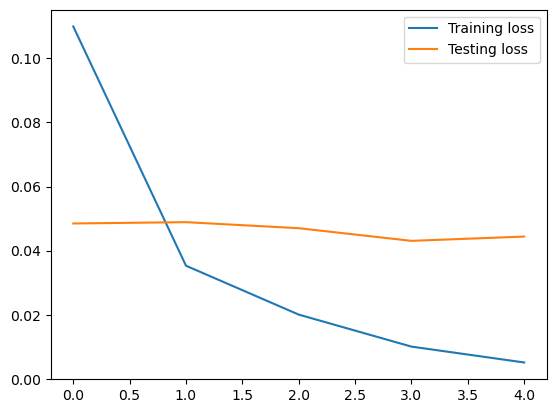

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [08:48<00:00,  1.49s/it]


Accuracy: 0.9893985182296744
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3870
           1       0.99      0.99      0.99     17201
           2       0.97      0.95      0.96      2374
           3       0.99      0.99      0.99     17587

    accuracy                           0.99     41032
   macro avg       0.98      0.98      0.98     41032
weighted avg       0.99      0.99      0.99     41032



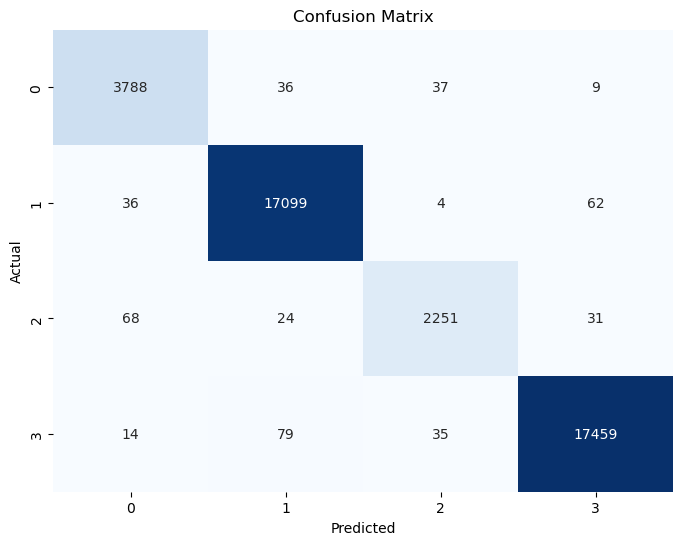

In [6]:
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss

# Define the loss function
loss_fn = CrossEntropyLoss().to(device)

# Define the number of training epochs
EPOCHS = 5

train_losses = []
test_losses = []

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'STARTING Epoch {epoch + 1}/{EPOCHS}')
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        model.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_loss = 0

    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_data_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

# Plotting the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(true_labels, predictions))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2 epochs with Roberta model:

```
Accuracy: 0.9721559074299635
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3908
           1       0.99      0.98      0.98     17162
           2       0.93      0.87      0.90      2410
           3       0.99      0.98      0.98     17570

    accuracy                           0.97     41050
   macro avg       0.95      0.95      0.95     41050
weighted avg       0.97      0.97      0.97     41050
```

5 epochs with BGE-Reranker large

```
Accuracy: 0.9645155000974849
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3870
           1       0.98      0.98      0.98     17201
           2       0.82      0.86      0.84      2374
           3       0.98      0.98      0.98     17587

    accuracy                           0.96     41032
   macro avg       0.92      0.93      0.93     41032
weighted avg       0.97      0.96      0.96     41032
```

5 epochs with BART-large-CNN
```
Accuracy: 0.9893985182296744
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3870
           1       0.99      0.99      0.99     17201
           2       0.97      0.95      0.96      2374
           3       0.99      0.99      0.99     17587

    accuracy                           0.99     41032
   macro avg       0.98      0.98      0.98     41032
weighted avg       0.99      0.99      0.99     41032
```

In [9]:
torch.save(model.state_dict(), "bart-large-cnn.pt")

In [ ]:
print("TODO!")

# model = Classifier(len(le.classes_), base_model).to(device)
# model.load_state_dict(torch.load("bart-large-cnn.pt")
# model.eval

## Multimodality

In [ ]:
# Create a PyTorch dataset
class ClassifierDataset(Dataset):
    def __init__(self, texts, labels, images, tokenizer, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels
        self.images = images.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = Compose([Resize((224, 224)), ToTensor(), Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        #print("IMAGE: " + './images/' + str(self.images[idx]) + '.jpg')
        image = Image.open('./images/' + str(self.images[idx]) + '.jpg').convert('RGB')
        image = self.transform(image)
        
        #print("TEXTS")
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders
def create_data_loader(texts, labels, tokenizer, images, max_len, batch_size):
    ds = ClassifierDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        images=images,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)

class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.drop = nn.Dropout(p=0.3)
        self.hidden = nn.Linear(self.roberta.config.hidden_size + self.vit.config.hidden_size, 128)  # Change 128 to your desired hidden layer size
        self.out = nn.Linear(128, n_classes)

        # TODO: add Xavier initialisation
        
    def forward(self, input_ids, attention_mask, image):
        text_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        image_output = self.vit(image)
        
        text_pooled_output = text_output.last_hidden_state[:, 0, :]
        image_pooled_output = image_output.last_hidden_state[:, 0, :]
        
        #print("TEXT SHAPE: " + str(text_pooled_output.shape))
        #print("IMAGE SHAPE: " + str(image_pooled_output.shape))
        
        # Simple fusion by concatenation
        combined = torch.cat((text_pooled_output, image_pooled_output), dim=1)
        
        output = self.drop(combined)
        output = nn.ReLU()(self.hidden(output))
        # return self.out(output) 
        return torch.nn.functional.log_softmax(self.out(output), dim=1)

In [ ]:
# Create a PyTorch dataset
class ClassifierDataset(Dataset):
    def __init__(self, texts, labels, images, tokenizer, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels
        self.images = images.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = Compose([Resize((224, 224)), ToTensor(), Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        image = Image.open(
            './images/' + str(self.images[idx]) + '.jpg').convert('RGB')
        image = self.transform(image)

        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders


def create_data_loader(texts, labels, tokenizer, images, max_len, batch_size):
    ds = ClassifierDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        images=images,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)


class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.drop = nn.Dropout(p=0.3)
        # Change 128 to your desired hidden layer size
        self.hidden = nn.Linear(self.roberta.config.hidden_size, 128)
        self.out = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask, image):
        text_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        image_output = self.vit(image)

        text_pooled_output = text_output.last_hidden_state[:, 0, :]
        image_pooled_output = image_output.last_hidden_state[:, 0, :]

        # Simple fusion by concatenation
        # combined = torch.cat((text_pooled_output, image_pooled_output), dim=1)
        # Using mul (*) operation
        # combined = text_pooled_output.mul(image_pooled_output)
        # using + operator
        combined = text_pooled_output + image_pooled_output
        # TODO: using einsum  (need to work out some bugs) 
        # combined = torch.einsum('ij,ij->ij', text_pooled_output, image_pooled_output)
        
        # print("SHAPE of combined: " + str(combined.shape))

        output = self.drop(combined)
        output = nn.ReLU()(self.hidden(output))
        # return self.out(output)
        return torch.nn.functional.log_softmax(self.out(output), dim=1)

In [ ]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pretrained model/tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base').to(device)

data_subset = df_combined#[:100]

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(data_subset['classification_by_editorial'])

# Split data into training and test sets
train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(
    data_subset['text'], data_subset["id"], encoded_labels, test_size=0.2, random_state=42)

BATCH_SIZE = 160  # 50 consumes 22GB of VRAM
MAX_LEN = 256

train_data_loader = create_data_loader(train_texts, train_labels, tokenizer, train_images, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, tokenizer, test_images, MAX_LEN, BATCH_SIZE)

# Initialize the classifier and optimizer
model = Classifier(len(le.classes_)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
# Define the loss function
loss_fn = CrossEntropyLoss().to(device)

# Define the number of training epochs
EPOCHS = 2

train_losses = []
test_losses = []

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'STARTING Epoch {epoch + 1}/{EPOCHS}')
    model.train()
    total_loss = 0

    for batch in tqdm(train_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        images = batch["image"].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_loss = 0

    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        images = batch["image"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, images)

        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

    avg_test_loss = total_loss / len(test_data_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

# Plotting the training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend()
plt.show()

# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_data_loader):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    images = batch["image"].to(device)
    
    with torch.no_grad():
            outputs = model(input_ids, attention_mask, images)

    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(true_labels, predictions))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

2 epochs of concatenation of the Roberta model and the CNN model:

```
Accuracy: 0.9848898420744785
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3870
           1       0.99      0.99      0.99     17201
           2       0.96      0.91      0.94      2374
           3       0.99      0.99      0.99     17587

    accuracy                           0.98     41032
   macro avg       0.97      0.97      0.97     41032
weighted avg       0.98      0.98      0.98     41032
```

### Pretrained multimodal models:

# Testing fusion approaches

In [ ]:
# create two tensort of the size 768 and 768
a = torch.randn(6, 768)
b = torch.randn(6, 768)

In [ ]:
# Basic element-wise multiplication

d = a.mul(b)
d.shape

In [ ]:
e = torch.matmul(a, b.reshape(768, 6))
e

In [ ]:
torch.matmul(a, b.T)

In [ ]:
(a * b) == d

In [ ]:
(a + b).shape

In [ ]:
f = torch.einsum('ik,jk->ij', a, b)
f

In [ ]:
f == (a * b)

In [ ]:
# compute einsum and normalise it
g = torch.einsum('ij,jk->ik', a, b.T)
g = torch.nn.functional.normalize(g, p=2, dim=1)
g

In [ ]:
i = torch.einsum('ij,jk->ik', a, b.reshape(768, 6))
i = torch.nn.functional.normalize(g, p=2, dim=1)
i

In [ ]:
h = torch.ger(a[0], b[0])
h.shape